In [ ]:
# Install the necessary packages
!pip install transformers datasets accelerate evaluate

In [ ]:
import torch
from transformers import BertForMaskedLM, BertConfig, AutoTokenizer

# Load teacher model (CodeBERT)
teacher_model = BertForMaskedLM.from_pretrained("microsoft/codebert-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer for consistent vocabulary
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create custom student model
def create_custom_student_model():
    student_config = BertConfig(
        hidden_size=512,  # Smaller hidden size
        num_attention_heads=8,  # Fewer attention heads
        num_hidden_layers=12,  # Same number of layers
        intermediate_size=2048,  # Reduced intermediate size
        vocab_size=tokenizer.vocab_size,  # Match tokenizer's vocab size
        hidden_act="gelu",  # Activation function
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=512,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        pad_token_id=0,
        position_embedding_type="absolute",
        use_cache=True,
        classifier_dropout=None
    )
    return BertForMaskedLM(student_config)

# Instantiate the student model
student_model = create_custom_student_model().to("cuda" if torch.cuda.is_available() else "cpu")

# Function to print model details
def print_model_size_and_params(model, model_name):
    # Calculate the number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Save the model to a temporary directory to calculate size
    model.save_pretrained(f"./temp_{model_name}")
    tokenizer.save_pretrained(f"./temp_{model_name}")  # Save tokenizer for complete size
    import os
    model_size = sum(os.path.getsize(f"./temp_{model_name}/{file}") for file in os.listdir(f"./temp_{model_name}"))

    # Print the results
    print(f"Model: {model_name}")
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Model Size on Disk: {model_size / 1e6:.2f} MB\n")

    # Clean up temporary files
    import shutil
    shutil.rmtree(f"./temp_{model_name}")

# Print size and parameter details for teacher and student models
print_model_size_and_params(teacher_model, "codebert_teacher")
print_model_size_and_params(student_model, "custom_student")


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: codebert_teacher
Total Parameters: 124697433
Trainable Parameters: 124697433
Model Size on Disk: 503.63 MB

Model: custom_student
Total Parameters: 64142425
Trainable Parameters: 64142425
Model Size on Disk: 261.41 MB



In [ ]:
import torch
from transformers import BertForMaskedLM, BertConfig, AutoTokenizer

# Load teacher model (CodeBERT)
teacher_model = BertForMaskedLM.from_pretrained("microsoft/codebert-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer for consistent vocabulary
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create custom student model
def create_custom_student_model():
    student_config = BertConfig(
        hidden_size=384,  # Smaller hidden size
        num_attention_heads=8,  # Fewer attention heads
        num_hidden_layers=12,  # Same number of layers
        intermediate_size=2048,  # Reduced intermediate size
        vocab_size=tokenizer.vocab_size,  # Match tokenizer's vocab size
        hidden_act="gelu",  # Activation function
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=512,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        pad_token_id=0,
        position_embedding_type="absolute",
        use_cache=True,
        classifier_dropout=None
    )
    return BertForMaskedLM(student_config)

# Instantiate the student model
student_model = create_custom_student_model().to("cuda" if torch.cuda.is_available() else "cpu")

# Function to print model details
def print_model_size_and_params(model, model_name):
    # Calculate the number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Save the model to a temporary directory to calculate size
    model.save_pretrained(f"./temp_{model_name}")
    tokenizer.save_pretrained(f"./temp_{model_name}")  # Save tokenizer for complete size
    import os
    model_size = sum(os.path.getsize(f"./temp_{model_name}/{file}") for file in os.listdir(f"./temp_{model_name}"))

    # Print the results
    print(f"Model: {model_name}")
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Model Size on Disk: {model_size / 1e6:.2f} MB\n")

    # Clean up temporary files
    import shutil
    shutil.rmtree(f"./temp_{model_name}")

# Print size and parameter details for teacher and student models
print_model_size_and_params(teacher_model, "codebert_teacher")
print_model_size_and_params(student_model, "custom_student")


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: codebert_teacher
Total Parameters: 124697433
Trainable Parameters: 124697433
Model Size on Disk: 503.63 MB

Model: custom_student
Total Parameters: 45717081
Trainable Parameters: 45717081
Model Size on Disk: 187.71 MB



# **arigos/diversevul dataset analysis**

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the DiverseVul dataset from Hugging Face
dataset = load_dataset("ArIgos/DiverseVul")



README.md:   0%|          | 0.00/807 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/138M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/297442 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Available Splits: dict_keys(['train', 'test', 'valid'])
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297442 entries, 0 to 297441
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   func       297442 non-null  object 
 1   target     297442 non-null  int64  
 2   cwe        297442 non-null  object 
 3   project    297442 non-null  object 
 4   commit_id  297442 non-null  object 
 5   hash       297442 non-null  float64
 6   size       297442 non-null  int64  
 7   message    297442 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 18.2+ MB
None

Sample Data:
                                                func  target  \
0  _rsvg_node_poly_free (RsvgNode * self)\n{\n   ...       0   
1  static gg_action_t gg_handle_connecting_gg(str...       0   
2  _rsvg_node_ellipse_draw (RsvgNode * self, Rsvg...       0   
3  int ssl3_get_server_certificate(SSL *s)\n{\n  ...       0   
4  asmli

In [ ]:
# Display the available splits
print("Available Splits:", dataset.keys())


Available Splits: dict_keys(['train', 'test', 'valid'])


In [ ]:

# Display basic info about the dataset
print("Dataset Info:")
print(train_data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297442 entries, 0 to 297441
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   func       297442 non-null  object 
 1   target     297442 non-null  int64  
 2   cwe        297442 non-null  object 
 3   project    297442 non-null  object 
 4   commit_id  297442 non-null  object 
 5   hash       297442 non-null  float64
 6   size       297442 non-null  int64  
 7   message    297442 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 18.2+ MB
None


In [ ]:
# Display sample data
print("\nSample Data:")
print(train_data.head())


Sample Data:
                                                func  target  \
0  _rsvg_node_poly_free (RsvgNode * self)\n{\n   ...       0   
1  static gg_action_t gg_handle_connecting_gg(str...       0   
2  _rsvg_node_ellipse_draw (RsvgNode * self, Rsvg...       0   
3  int ssl3_get_server_certificate(SSL *s)\n{\n  ...       0   
4  asmlinkage long compat_sys_newlstat(char __use...       0   

                 cwe    project                                 commit_id  \
0                 []    librsvg  34c95743ca692ea0e44778e41a7c0a129363de84   
1          [CWE-310]    libgadu  035e3cf6227995bdbe95f663a938a3838131e022   
2  [CWE-20, CWE-119]    librsvg  40af93e6eb1c94b90c3b9a0b87e0840e126bb8df   
3                 []    openssl  1392c238657ec745af6a40def03d67d4ce02a082   
4                 []  linux-2.6  822191a2fa1584a29c3224ab328507adcaeac1ab   

           hash  size                                            message  
0  3.204296e+38     8  Store node type separately in RsvgNode\n

In [ ]:
# Select a specific row, e.g., the first row
row = train_data.iloc[0]  # Adjust the index if you want a different row

# Print each column's information on a separate line
for column in train_data.columns:
    print(f"{column}: {row[column]}")


func: _rsvg_node_poly_free (RsvgNode * self)
{
    RsvgNodePoly *z = (RsvgNodePoly *) self;
    if (z->pointlist)
        g_free (z->pointlist);
    _rsvg_node_finalize (&z->super);
    g_free (z);
}
target: 0
cwe: []
project: librsvg
commit_id: 34c95743ca692ea0e44778e41a7c0a129363de84
hash: 3.204295516990888e+38
size: 8
message: Store node type separately in RsvgNode

The node name (formerly RsvgNode:type) cannot be used to infer
the sub-type of RsvgNode that we're dealing with, since for unknown
elements we put type = node-name. This lead to a (potentially exploitable)
crash e.g. when the element name started with "fe" which tricked
the old code into considering it as a RsvgFilterPrimitive.

CVE-2011-3146

https://bugzilla.gnome.org/show_bug.cgi?id=658014


In [ ]:
# Convert the train split to a DataFrame for easier analysis
train_data = dataset["train"].to_pandas()

# 1. Label Distribution Analysis
label_counts = train_data["target"].value_counts()
print("\nLabel Distribution:")
print(label_counts)


Label Distribution:
target
0    280397
1     17045
Name: count, dtype: int64


<ipython-input-12-78682990ff01>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


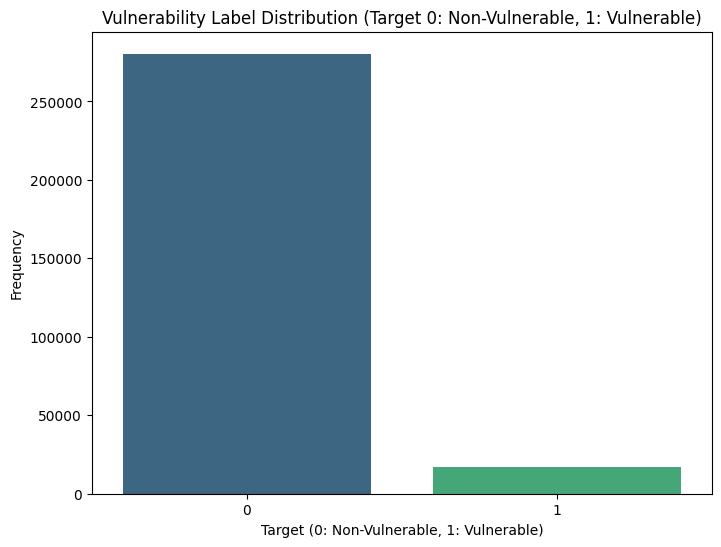

In [ ]:
# Plot label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Vulnerability Label Distribution (Target 0: Non-Vulnerable, 1: Vulnerable)")
plt.xlabel("Target (0: Non-Vulnerable, 1: Vulnerable)")
plt.ylabel("Frequency")
plt.show()


Top CWEs (Common Weakness Enumerations):
Series([], Name: count, dtype: int64)


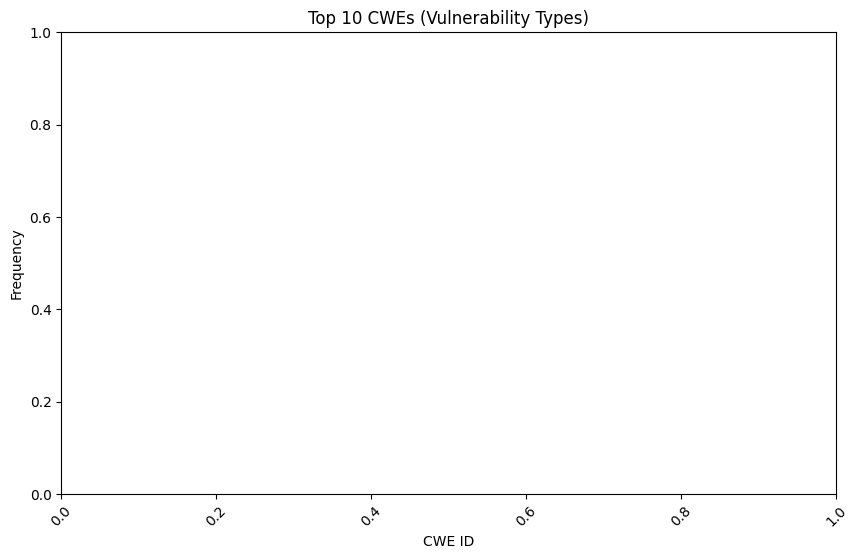

In [ ]:
# 2. CWE Distribution
# Clean up and count unique CWEs
cwe_counts = train_data["cwe"].apply(lambda x: x if isinstance(x, list) else []).explode().value_counts()
print("\nTop CWEs (Common Weakness Enumerations):")
print(cwe_counts.head(10))

# Plot CWE distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=cwe_counts.index, y=cwe_counts.values, palette="coolwarm")
plt.title("Top 10 CWEs (Vulnerability Types)")
plt.xlabel("CWE ID")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


Function Size Statistics:
count    297442.000000
mean         43.471083
std         127.518162
min           1.000000
25%           9.000000
50%          19.000000
75%          43.000000
max       24047.000000
Name: size, dtype: float64


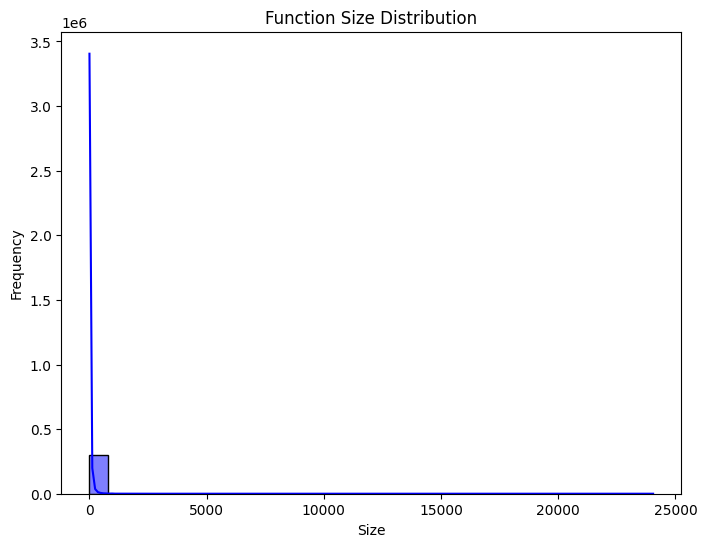

In [ ]:

# 3. Function Size Distribution
print("\nFunction Size Statistics:")
print(train_data["size"].describe())

# Plot function size distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_data["size"], bins=30, kde=True, color="blue")
plt.title("Function Size Distribution")
plt.xlabel("Size")
plt.ylabel("Frequency")
plt.show()


Top 10 Projects by Sample Count:
project
linux         65161
linux-2.6      9565
php-src        8150
server         7249
qemu           6740
gpac           6070
openssl        5613
vim            5500
envoy          5271
tensorflow     4557
Name: count, dtype: int64


<ipython-input-15-9af158594c2d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=project_counts.index, y=project_counts.values, palette="viridis")


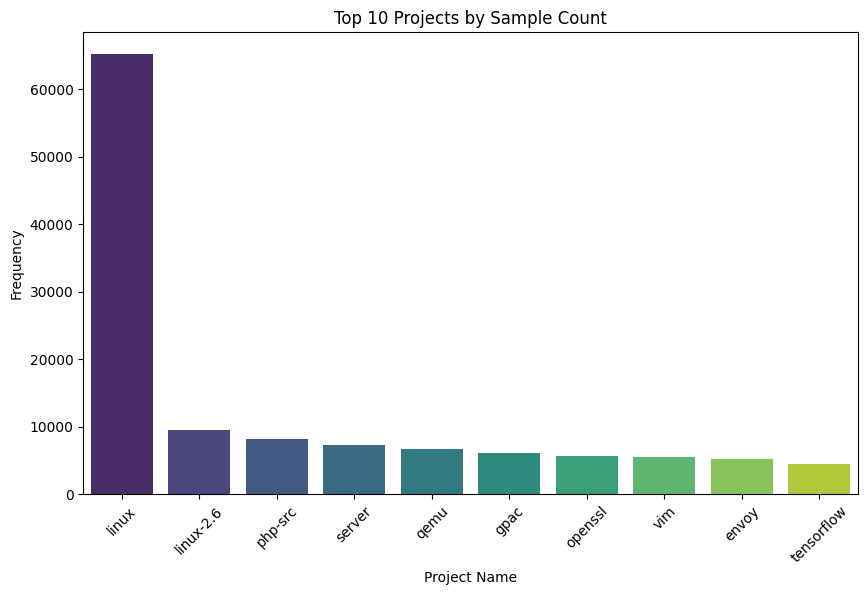

In [ ]:
# 4. Project Contributions
project_counts = train_data["project"].value_counts().head(10)  # Top 10 projects by count
print("\nTop 10 Projects by Sample Count:")
print(project_counts)

# Plot project contributions
plt.figure(figsize=(10, 6))
sns.barplot(x=project_counts.index, y=project_counts.values, palette="viridis")
plt.title("Top 10 Projects by Sample Count")
plt.xlabel("Project Name")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 5. Commit Message Analysis
# Analyze the commit messages (top 10 most frequent words)
from collections import Counter
import re

# Clean commit messages (remove special characters, etc.)
messages = train_data["message"].apply(lambda x: ' '.join(re.findall(r'\w+', str(x).lower())))
message_words = ' '.join(messages).split()
word_counts = Counter(message_words)

# Show the 10 most common words in commit messages
print("\nMost Common Words in Commit Messages:")
print(word_counts.most_common(10))


Most Common Words in Commit Messages:
[('the', 1029375), ('to', 564808), ('by', 485424), ('in', 413695), ('a', 410713), ('and', 334581), ('is', 321267), ('of', 314673), ('com', 261716), ('this', 244456)]


<ipython-input-17-f0aa392900be>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in word_counts.most_common(10)], y=[x[1] for x in word_counts.most_common(10)], palette="coolwarm")


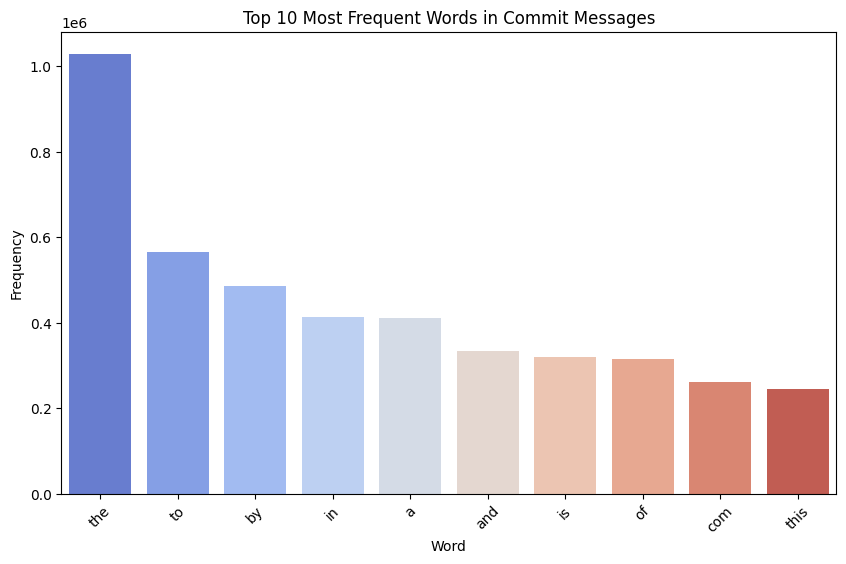

In [ ]:
# Plot word frequency in commit messages
plt.figure(figsize=(10, 6))
sns.barplot(x=[x[0] for x in word_counts.most_common(10)], y=[x[1] for x in word_counts.most_common(10)], palette="coolwarm")
plt.title("Top 10 Most Frequent Words in Commit Messages")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import os
import json
import torch
from transformers import BertConfig, BertForMaskedLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate

# Disable tokenizers parallelism to avoid issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check if GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
dataset = load_dataset("ArIgos/DiverseVul")
print(dataset['train'][0])  # Inspect a sample from the dataset

# Tokenization Function for the dataset
def tokenize_data(examples):
    return tokenizer(examples['func'], padding="max_length", truncation=True, max_length=512)

# Apply preprocessing to all splits (train, validation, test)
tokenized_train = dataset['train'].map(tokenize_data, batched=True, remove_columns=["func"])
tokenized_validation = dataset['test'].map(tokenize_data, batched=True, remove_columns=["func"])

# Create Teacher Model with Knowledge Distillation Setup
teacher_model = BertForMaskedLM.from_pretrained("microsoft/codebert-base", ignore_mismatched_sizes=True).to(device)

# Create Custom Student Model
def create_custom_student_model():
    student_config = BertConfig(
        hidden_size=384,  # Custom hidden size for smaller model
        num_attention_heads=6,  # Smaller number of attention heads
        num_hidden_layers=6,  # Fewer layers
        intermediate_size=1536,
        vocab_size=tokenizer.vocab_size,
        hidden_act="gelu",
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=512,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        pad_token_id=0,
        position_embedding_type="absolute",
        use_cache=True,
        classifier_dropout=None
    )
    return BertForMaskedLM(student_config)

# Initialize the student model
student_model = create_custom_student_model().to(device)

# Set the output directory
output_dir = './results_wikitext'

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

# Training Arguments for Knowledge Distillation
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir='./logs_wikitext',
    logging_steps=500,
    output_dir=output_dir,
    do_train=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    dataloader_num_workers=0,
    gradient_accumulation_steps=2,
    logging_strategy="steps",
    save_total_limit=2
)

# Custom Loss Function for Knowledge Distillation
def distillation_loss(student_logits, teacher_logits, temperature=2.0):
    student_probs = torch.nn.functional.log_softmax(student_logits / temperature, dim=-1)
    teacher_probs = torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    return torch.nn.functional.kl_div(student_probs, teacher_probs, reduction="batchmean") * (temperature ** 2)

# Data Collator
def data_collator(features):
    batch = {k: torch.tensor([f[k] for f in features]) for k in features[0]}
    return batch

# Metrics Calculation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "eval_accuracy": accuracy["accuracy"],
        "eval_f1": f1["f1"],
        "eval_precision": precision["precision"],
        "eval_recall": recall["recall"],
    }

class DistillationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Forward pass for the student model
        student_outputs = model(**inputs)

        # Forward pass for the teacher model (without gradients)
        with torch.no_grad():
            teacher_outputs = teacher_model(**inputs)

        # Calculate distillation loss
        loss = distillation_loss(student_outputs.logits, teacher_outputs.logits, temperature=2.0)

        # Return the loss and outputs from the student model
        return (loss, student_outputs) if return_outputs else loss

trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the Student Model with Knowledge Distillation
trainer.train()

# Save the Distilled Model after Knowledge Distillation
distilled_model_save_path = 'newmodel_codetbert.pth'
torch.save(student_model.state_dict(), distilled_model_save_path)


ModuleNotFoundError: No module named 'datasets'

# **Distilling Another way**

In [ ]:
!pip install transformers datasets evaluate torch numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import json
import torch
import datetime
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from transformers import (
    BertConfig,
    BertForMaskedLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from typing import Dict, List, Optional

# Check GPU availability
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Device: Tesla T4


In [ ]:
'''
class DistillationConfig:
    def __init__(self):
        self.seed = 42
        self.max_length = 512
        self.train_batch_size = 64  # Reduced for Colab
        self.eval_batch_size = 64   # Reduced for Colab
        self.num_epochs = 3
        self.learning_rate = 2e-5
        self.weight_decay = 0.01
        self.warmup_ratio = 0.1
        self.temperature = 2.0
        self.alpha = 0.5
        self.teacher_model_name = "microsoft/codebert-base"
        self.output_dir = "/content/distilled_model"  # Colab path
        self.logging_dir = "/content/logs"            # Colab path
        self.dataset_name = "ArIgos/DiverseVul"

        # Student model configuration (reduced size for Colab)
        self.student_config = {
            "hidden_size": 384,
            "num_attention_heads": 6,
            "num_hidden_layers": 8,
            "intermediate_size":2048 ,
            "hidden_dropout_prob": 0.2,
            "attention_probs_dropout_prob": 0.2,
        }

        # Additional training configuration
        self.gradient_accumulation_steps = 4
        self.max_grad_norm = 1.0
        self.logging_steps = 100
        self.save_steps = 500
        self.eval_steps = 500
'''

In [ ]:
class DistillationConfig:
    def __init__(self):
        # General configuration
        self.seed = 42
        self.max_length = 768  # Increased to handle longer contexts
        self.train_batch_size = 64  # Batch size suitable for Colab
        self.eval_batch_size = 64   # Batch size suitable for Colab
        self.num_epochs = 5  # Increased for better learning of complex patterns
        self.learning_rate = 1e-5  # Lower learning rate for better stability
        self.weight_decay = 0.01
        self.warmup_ratio = 0.2  # Increased for smoother learning rate warmup
        self.temperature = 1.5  # Adjusted for better balance between soft and hard labels
        self.alpha = 0.5
        self.teacher_model_name = "microsoft/codebert-base"
        self.output_dir = "/content/distilled_model"  # Colab path
        self.logging_dir = "/content/logs"            # Colab path
        self.dataset_name = "ArIgos/DiverseVul"

        # Student model configuration (reduced size for Colab)
        self.student_config = {
            "hidden_size": 384,
            "num_attention_heads": 6,
            "num_hidden_layers": 8,
            "intermediate_size": 2048,
            "hidden_dropout_prob": 0.2,
            "attention_probs_dropout_prob": 0.2,
        }

        # Additional training configuration
        self.gradient_accumulation_steps = 8  # Increased for larger effective batch size
        self.max_grad_norm = 1.0
        self.logging_steps = 50  # More frequent logging
        self.save_steps = 500
        self.eval_steps = 100  # More frequent evaluation for better monitoring


In [ ]:
class VulnerabilityDataset:
    def __init__(self, config: DistillationConfig):
        self.config = config
        self.tokenizer = AutoTokenizer.from_pretrained(config.teacher_model_name)
        self.dataset = None
        self.tokenized_datasets = None

    def load_and_preprocess(self):
        print("Loading dataset...")
        self.dataset = load_dataset(self.config.dataset_name)

        def tokenize_and_mask_function(examples):
            # Tokenize the text
            tokenized = self.tokenizer(
                examples['func'],
                padding="max_length",
                truncation=True,
                max_length=self.config.max_length,
                return_tensors="pt"
            )

            # Create input_ids and attention_mask
            inputs = {
                'input_ids': tokenized['input_ids'],
                'attention_mask': tokenized['attention_mask'],
            }

            # Create labels for MLM (copy input_ids)
            inputs['labels'] = inputs['input_ids'].clone()

            return inputs

        print("Tokenizing datasets...")
        self.tokenized_datasets = {
            'train': self.dataset['train'].map(
                tokenize_and_mask_function,
                batched=True,
                remove_columns=self.dataset['train'].column_names,
                desc="Tokenizing train set"
            ),
            'validation': self.dataset['test'].map(
                tokenize_and_mask_function,
                batched=True,
                remove_columns=self.dataset['test'].column_names,
                desc="Tokenizing validation set"
            )
        }

        # Set format for PyTorch
        self.tokenized_datasets['train'].set_format('torch')
        self.tokenized_datasets['validation'].set_format('torch')

        print("Dataset preprocessing completed")
        return self.tokenized_datasets

In [ ]:
class DistillationTrainer(Trainer):
    def __init__(self, teacher_model, temperature=2.0, alpha=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        self.temperature = temperature
        self.alpha = alpha

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Make sure we only pass supported inputs to the model
        model_inputs = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'labels': inputs['labels']
        }

        # Forward pass through student
        student_outputs = model(**model_inputs)
        student_logits = student_outputs.logits

        # Forward pass through teacher
        with torch.no_grad():
            teacher_outputs = self.teacher_model(**model_inputs)
            teacher_logits = teacher_outputs.logits

        # Calculate distillation loss
        loss = self.distillation_loss(
            student_logits,
            teacher_logits,
            model_inputs.get('labels'),
            self.alpha,
            self.temperature
        )

        # Scale loss if num_items_in_batch is provided
        if num_items_in_batch is not None and num_items_in_batch > 0:
            batch_size = model_inputs["input_ids"].size(0)
            loss = loss * (batch_size / num_items_in_batch)

        return (loss, student_outputs) if return_outputs else loss

    def distillation_loss(self, student_logits, teacher_logits, labels=None, alpha=0.5, temperature=2.0):
        # Calculate soft targets distillation loss
        distillation_loss = torch.nn.functional.kl_div(
            torch.nn.functional.log_softmax(student_logits / temperature, dim=-1),
            torch.nn.functional.softmax(teacher_logits / temperature, dim=-1),
            reduction='batchmean'
        ) * (temperature ** 2)

        if labels is not None:
            # Calculate hard targets cross entropy loss
            ce_loss = torch.nn.functional.cross_entropy(student_logits.view(-1, student_logits.size(-1)),
                                                      labels.view(-1),
                                                      ignore_index=-100)
            return (alpha * distillation_loss) + ((1 - alpha) * ce_loss)

        return distillation_loss

class DistillationModel:
    def __init__(self, config: DistillationConfig, tokenizer):
        self.config = config
        self.tokenizer = tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        print("Loading teacher model...")
        self.teacher_model = self._load_teacher_model()

        print("Creating student model...")
        self.student_model = self._create_student_model()

    def _load_teacher_model(self):
        teacher = BertForMaskedLM.from_pretrained(
            self.config.teacher_model_name,
            ignore_mismatched_sizes=True
        ).to(self.device)
        teacher.eval()
        return teacher

    def _create_student_model(self):
        student_config = BertConfig(
            vocab_size=self.tokenizer.vocab_size,
            max_position_embeddings=self.config.max_length,
            type_vocab_size=2,
            layer_norm_eps=1e-12,
            pad_token_id=0,
            position_embedding_type="absolute",
            use_cache=True,
            **self.config.student_config
        )
        return BertForMaskedLM(student_config).to(self.device)

In [ ]:
def train_model():
    # Initialize configuration
    config = DistillationConfig()

    # Set seed for reproducibility
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)

    # Initialize dataset
    dataset_handler = VulnerabilityDataset(config)
    tokenized_datasets = dataset_handler.load_and_preprocess()

    # Initialize models
    distillation_model = DistillationModel(config, dataset_handler.tokenizer)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=config.output_dir,
        overwrite_output_dir=True,
        num_train_epochs=config.num_epochs,
        per_device_train_batch_size=config.train_batch_size,
        per_device_eval_batch_size=config.eval_batch_size,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        warmup_ratio=config.warmup_ratio,
        logging_dir=config.logging_dir,
        logging_steps=config.logging_steps,
        eval_steps=config.eval_steps,
        save_steps=config.save_steps,
        evaluation_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        max_grad_norm=config.max_grad_norm,
        save_total_limit=2,
    )

    # Define data collator
    def data_collator(features):
        batch = {
            'input_ids': torch.stack([f['input_ids'] for f in features]),
            'attention_mask': torch.stack([f['attention_mask'] for f in features]),
            'labels': torch.stack([f['labels'] for f in features]),
        }
        return batch

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = predictions.argmax(axis=-1)

        # Filter out padding tokens (usually -100)
        mask = labels != -100
        predictions = predictions[mask]
        labels = labels[mask]

        metrics = {
            "accuracy": evaluate.load("accuracy").compute(predictions=predictions, references=labels),
            "f1": evaluate.load("f1").compute(predictions=predictions, references=labels, average='weighted'),
            "precision": evaluate.load("precision").compute(predictions=predictions, references=labels, average='weighted'),
            "recall": evaluate.load("recall").compute(predictions=predictions, references=labels, average='weighted')
        }

        return {k: v['score'] if isinstance(v, dict) else v for k, v in metrics.items()}

    # Initialize trainer
    trainer = DistillationTrainer(
        teacher_model=distillation_model.teacher_model,
        temperature=config.temperature,
        alpha=config.alpha,
        model=distillation_model.student_model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    print("Starting training...")
    trainer.train()

    print("Evaluating model...")
    eval_results = trainer.evaluate()

    # Save the model and results
    output_dir = Path(config.output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    trainer.save_model(str(output_dir / "Samll_code_model"))

    with open(output_dir / "eval_results.json", "w") as f:
        json.dump(eval_results, f, indent=4)

    with open(output_dir / "config.json", "w") as f:
        config_dict = {k: v for k, v in config.__dict__.items() if not k.startswith('_')}
        json.dump(config_dict, f, indent=4)

    print(f"Training completed. Model and results saved to {config.output_dir}")
    return eval_results

In [ ]:
# Run the training
eval_results = train_model()
print("\nFinal Evaluation Results:")
print(json.dumps(eval_results, indent=2))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Loading dataset...


README.md:   0%|          | 0.00/807 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/138M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/297442 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Tokenizing datasets...


Tokenizing train set:   0%|          | 0/297442 [00:00<?, ? examples/s]

Tokenizing validation set:   0%|          | 0/16525 [00:00<?, ? examples/s]

Dataset preprocessing completed
Using device: cuda
Loading teacher model...


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of BertForMaskedLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['cls.predictions.bias', 'cls.p

Creating student model...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.60 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.60 GiB is free. Process 11146 has 13.15 GiB memory in use. Of the allocated memory 12.87 GiB is allocated by PyTorch, and 154.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from transformers import RobertaConfig, RobertaForMaskedLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
import torch
import os
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear unnecessary files to free up space
def clear_cache():
    os.system("rm -rf /root/.cache/huggingface")
    os.system("rm -rf /root/.cache/torch")

clear_cache()

# Load the pre-trained CodeBERT model (teacher)
teacher_model = RobertaForMaskedLM.from_pretrained("microsoft/codebert-base").to(device)
teacher_model.eval()

# Load the tokenizer for CodeBERT
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create a custom CodeBERTa-based student model
def create_custom_student_model():
    student_config = RobertaConfig(
        vocab_size=50265,  # Same as CodeBERTa tokenizer
        hidden_size=384,  # Reduced hidden size
        num_attention_heads=6,  # Reduced number of attention heads
        num_hidden_layers=6,  # Reduced number of layers
        intermediate_size=1536,  # Intermediate size for feed-forward layers
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=514,
        type_vocab_size=1,  # For CodeBERTa, type_vocab_size is 1
        layer_norm_eps=1e-5,
    )
    return RobertaForMaskedLM(student_config)

# Instantiate the student model
student_model = create_custom_student_model().to(device)

# Distillation loss function
def distillation_loss(teacher_logits, student_logits, temperature=2.0):
    return torch.nn.KLDivLoss(reduction="batchmean")(
        torch.nn.functional.log_softmax(student_logits / temperature, dim=-1),
        torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    )

# Load the dataset
dataset = load_dataset("ArIgos/DiverseVul")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples['func'],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_attention_mask=True
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['func'])

# DataLoader for efficient batching
def get_dataloader(data, batch_size=8):
    def collate_fn(batch):
        batch_inputs = [torch.tensor(example['input_ids']) for example in batch]
        batch_masks = [torch.tensor(example['attention_mask']) for example in batch]

        # Pad sequences to the maximum length in the batch
        input_ids = pad_sequence(batch_inputs, batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_mask = pad_sequence(batch_masks, batch_first=True, padding_value=0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

    sampler = RandomSampler(data)
    return DataLoader(data, sampler=sampler, batch_size=batch_size, collate_fn=collate_fn)

# Training loop with distillation
def train_student_with_distillation(teacher_model, student_model, data, temperature=2.0, epochs=8, batch_size=8):
    optimizer = AdamW(student_model.parameters(), lr=5e-5)
    scaler = GradScaler()

    train_dataloader = get_dataloader(data, batch_size=batch_size)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    loss_values = []

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0.0

        for step, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            with autocast():
                student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
                student_logits = student_outputs.logits

                with torch.no_grad():
                    teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                    teacher_logits = teacher_outputs.logits

                loss = distillation_loss(teacher_logits, student_logits, temperature)
                total_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            if step % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Step {step}/{len(train_dataloader)}, Loss: {loss.item()}")

        avg_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

        # Clear CUDA cache to free memory
        torch.cuda.empty_cache()

    # Save the student model after training is complete
    save_model(student_model)

    return loss_values

# Save function for the student model
def save_model(model, filename="codeberta_student_model.pth"):
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

# Train the student model with knowledge distillation and collect loss values
loss_values = train_student_with_distillation(
    teacher_model,
    student_model,
    tokenized_dataset["train"],
    temperature=2.0
)

# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/807 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/138M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/297442 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Map:   0%|          | 0/297442 [00:00<?, ? examples/s]

Map:   0%|          | 0/16525 [00:00<?, ? examples/s]

Map:   0%|          | 0/16525 [00:00<?, ? examples/s]

<ipython-input-6-2167ffd73338>:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-2167ffd73338>:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/8, Step 0/37181, Loss: 204.14334106445312
Epoch 1/8, Step 100/37181, Loss: 107.33629608154297
Epoch 1/8, Step 200/37181, Loss: 71.78240203857422
Epoch 1/8, Step 300/37181, Loss: 59.16651153564453
Epoch 1/8, Step 400/37181, Loss: 51.250938415527344
Epoch 1/8, Step 500/37181, Loss: 53.23344802856445
Epoch 1/8, Step 600/37181, Loss: 50.68223571777344
Epoch 1/8, Step 700/37181, Loss: 46.2875862121582
Epoch 1/8, Step 800/37181, Loss: 41.62690734863281
Epoch 1/8, Step 900/37181, Loss: 42.67972183227539
Epoch 1/8, Step 1000/37181, Loss: 40.90312194824219
Epoch 1/8, Step 1100/37181, Loss: 40.532413482666016
Epoch 1/8, Step 1200/37181, Loss: 37.28588104248047
Epoch 1/8, Step 1300/37181, Loss: 36.253150939941406
Epoch 1/8, Step 1400/37181, Loss: 32.93001174926758
Epoch 1/8, Step 1500/37181, Loss: 36.355857849121094
Epoch 1/8, Step 1600/37181, Loss: 36.838050842285156
Epoch 1/8, Step 1700/37181, Loss: 33.21278381347656
Epoch 1/8, Step 1800/37181, Loss: 30.887788772583008
Epoch 1/8, Step 1

In [ ]:
!pip install evaluate

In [ ]:
from datasets import load_dataset
from evaluate import load as load_metric


In [ ]:
from transformers import RobertaConfig, RobertaForSequenceClassification, AutoTokenizer, AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import os
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear unnecessary files to free up space
def clear_cache():
    os.system("rm -rf /root/.cache/huggingface")
    os.system("rm -rf /root/.cache/torch")

clear_cache()

# Load the pre-trained CodeBERT model (teacher)
teacher_model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2).to(device)
teacher_model.eval()

# Load the tokenizer for CodeBERT
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create a custom CodeBERTa-based student model
def create_custom_student_model():
    student_config = RobertaConfig(
        vocab_size=50265,
        hidden_size=384,
        num_attention_heads=6,
        num_hidden_layers=8,
        intermediate_size=2048,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=514,
        type_vocab_size=1,
        layer_norm_eps=1e-5,
        num_labels=2
    )
    return RobertaForSequenceClassification(student_config)

# Instantiate the student model
student_model = create_custom_student_model().to(device)

# Distillation loss function
def distillation_loss(teacher_logits, student_logits, temperature=2.0):
    return torch.nn.KLDivLoss(reduction="batchmean")(
        torch.nn.functional.log_softmax(student_logits / temperature, dim=-1),
        torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    )

# Load the dataset for vulnerability detection
dataset = load_dataset("ArIgos/DiverseVul")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['func'], padding="max_length", truncation=True, max_length=128, return_attention_mask=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['func'])

# Split dataset into train and validation sets
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['test']

# DataLoader for efficient batching
def get_dataloader(data, batch_size=8):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(example['input_ids'], dtype=torch.long) for example in batch])
        attention_mask = torch.stack([torch.tensor(example['attention_mask'], dtype=torch.long) for example in batch])
        labels = torch.tensor([example['target'] for example in batch], dtype=torch.long)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}

    sampler = RandomSampler(data)
    return DataLoader(data, sampler=sampler, batch_size=batch_size, collate_fn=collate_fn)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")

    return avg_loss, accuracy, f1, precision, recall

# Training loop with evaluation
def train_student_with_distillation(
    teacher_model, student_model, train_data, val_data, temperature=2.0, epochs=3, batch_size=8
):
    optimizer = AdamW(student_model.parameters(), lr=5e-5)
    scaler = GradScaler()

    train_dataloader = get_dataloader(train_data, batch_size=batch_size)
    val_dataloader = get_dataloader(val_data, batch_size=batch_size)

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    metrics_history = []

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0.0

        for step, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with autocast():
                student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                student_logits = student_outputs.logits

                with torch.no_grad():
                    teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                    teacher_logits = teacher_outputs.logits

                loss = distillation_loss(teacher_logits, student_logits, temperature) + student_outputs.loss
                total_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            if step % 1000 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Step {step}/{len(train_dataloader)}, Loss: {loss.item()}")

        # Compute training loss and metrics
        train_loss, train_acc, train_f1, train_precision, train_recall = evaluate_model(student_model, train_dataloader)
        # Compute validation loss and metrics
        val_loss, val_acc, val_f1, val_precision, val_recall = evaluate_model(student_model, val_dataloader)

        # Log metrics
        metrics_history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "train_f1": train_f1,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "val_f1": val_f1,
            "val_precision": val_precision,
            "val_recall": val_recall,
        })

        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        torch.cuda.empty_cache()

    save_model_and_tokenizer(student_model, tokenizer)
    return metrics_history

# Save the model and tokenizer
def save_model_and_tokenizer(model, tokenizer, directory="student_model"):
    if not os.path.exists(directory):
        os.makedirs(directory)

    torch.save(model.state_dict(), os.path.join(directory, "pytorch_model.bin"))
    tokenizer.save_pretrained(directory)
    model.config.save_pretrained(directory)
    print(f"Model saved to {directory}")

# Automatically download the model and files
def download_model_files(directory="student_model"):
    import shutil
    zip_name = f"{directory}.zip"
    shutil.make_archive(directory, 'zip', directory)
    print(f"Model files archived as {zip_name}")

# Train and evaluate the model
metrics_history = train_student_with_distillation(
    teacher_model,
    student_model,
    train_dataset,
    val_dataset,
    temperature=2.0,
    epochs=8
)

# Plot the training and validation metrics
epochs = [metrics["epoch"] for metrics in metrics_history]
train_losses = [metrics["train_loss"] for metrics in metrics_history]
val_losses = [metrics["val_loss"] for metrics in metrics_history]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Print the metrics history for reference
for metrics in metrics_history:
    print(metrics)

# Download the saved model and tokenizer files
download_model_files()


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/807 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/138M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/297442 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/16525 [00:00<?, ? examples/s]

Map:   0%|          | 0/297442 [00:00<?, ? examples/s]

Map:   0%|          | 0/16525 [00:00<?, ? examples/s]

Map:   0%|          | 0/16525 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-14-d0ba1ed458cf>:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-14-d0ba1ed458cf>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/8, Step 0/37181, Loss: 0.7361974120140076
Epoch 1/8, Step 1000/37181, Loss: 0.8526645302772522
Epoch 1/8, Step 2000/37181, Loss: 0.28844889998435974
Epoch 1/8, Step 3000/37181, Loss: 0.2991950213909149
Epoch 1/8, Step 4000/37181, Loss: 0.2981375753879547
Epoch 1/8, Step 5000/37181, Loss: 0.4963100850582123
Epoch 1/8, Step 6000/37181, Loss: 0.2929628789424896
Epoch 1/8, Step 7000/37181, Loss: 0.5077798366546631
Epoch 1/8, Step 8000/37181, Loss: 0.3055368661880493
Epoch 1/8, Step 9000/37181, Loss: 0.30064380168914795
Epoch 1/8, Step 10000/37181, Loss: 0.4268474578857422
Epoch 1/8, Step 11000/37181, Loss: 0.29957884550094604
Epoch 1/8, Step 12000/37181, Loss: 0.5025186538696289
Epoch 1/8, Step 13000/37181, Loss: 0.30687186121940613
Epoch 1/8, Step 14000/37181, Loss: 0.5015853047370911
Epoch 1/8, Step 15000/37181, Loss: 0.2970607876777649
Epoch 1/8, Step 16000/37181, Loss: 0.3062216639518738
Epoch 1/8, Step 17000/37181, Loss: 0.3035450279712677
Epoch 1/8, Step 18000/37181, Loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-14-d0ba1ed458cf>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1:
  Train Loss: 0.2822, Accuracy: 0.9427, F1: 0.9149, Precision: 0.8887, Recall: 0.9427
  Val Loss: 0.2853, Accuracy: 0.9407, F1: 0.9119, Precision: 0.8849, Recall: 0.9407
Epoch 2/8, Step 0/37181, Loss: 0.30164313316345215
Epoch 2/8, Step 1000/37181, Loss: 0.3048005998134613
Epoch 2/8, Step 2000/37181, Loss: 0.6775143146514893
Epoch 2/8, Step 3000/37181, Loss: 0.4941119849681854
Epoch 2/8, Step 4000/37181, Loss: 0.2997435927391052
Epoch 2/8, Step 5000/37181, Loss: 0.4932941496372223
Epoch 2/8, Step 6000/37181, Loss: 0.5011312961578369
Epoch 2/8, Step 7000/37181, Loss: 0.3009447455406189
Epoch 2/8, Step 8000/37181, Loss: 0.29473477602005005
Epoch 2/8, Step 9000/37181, Loss: 0.6966619491577148
Epoch 2/8, Step 10000/37181, Loss: 0.4959638714790344
Epoch 2/8, Step 11000/37181, Loss: 0.300054669380188
Epoch 2/8, Step 12000/37181, Loss: 0.29702097177505493
Epoch 2/8, Step 13000/37181, Loss: 0.2982092499732971
Epoch 2/8, Step 14000/37181, Loss: 0.5054289102554321
Epoch 2/8, Step 15000/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-14-d0ba1ed458cf>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2:
  Train Loss: 0.2752, Accuracy: 0.9427, F1: 0.9149, Precision: 0.8887, Recall: 0.9427
  Val Loss: 0.2783, Accuracy: 0.9407, F1: 0.9119, Precision: 0.8849, Recall: 0.9407
Epoch 3/8, Step 0/37181, Loss: 0.29756420850753784
Epoch 3/8, Step 1000/37181, Loss: 0.49310538172721863
Epoch 3/8, Step 2000/37181, Loss: 0.3034750819206238
Epoch 3/8, Step 3000/37181, Loss: 0.2946089506149292
Epoch 3/8, Step 4000/37181, Loss: 0.2999739944934845
Epoch 3/8, Step 5000/37181, Loss: 0.505561113357544
Epoch 3/8, Step 6000/37181, Loss: 0.4871925115585327
Epoch 3/8, Step 7000/37181, Loss: 0.2949207127094269
Epoch 3/8, Step 8000/37181, Loss: 0.3051490783691406
Epoch 3/8, Step 9000/37181, Loss: 0.49820923805236816
Epoch 3/8, Step 10000/37181, Loss: 0.301213800907135
Epoch 3/8, Step 11000/37181, Loss: 0.300701767206192
Epoch 3/8, Step 12000/37181, Loss: 0.4926040768623352
Epoch 3/8, Step 13000/37181, Loss: 0.29462575912475586
Epoch 3/8, Step 14000/37181, Loss: 0.3010386526584625
Epoch 3/8, Step 15000/3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-14-d0ba1ed458cf>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3:
  Train Loss: 0.2730, Accuracy: 0.9427, F1: 0.9149, Precision: 0.8887, Recall: 0.9427
  Val Loss: 0.2762, Accuracy: 0.9407, F1: 0.9119, Precision: 0.8849, Recall: 0.9407
Epoch 4/8, Step 0/37181, Loss: 0.29933440685272217
Epoch 4/8, Step 1000/37181, Loss: 0.6749185919761658
Epoch 4/8, Step 2000/37181, Loss: 0.3074806034564972


In [ ]:
from transformers import RobertaConfig, RobertaForSequenceClassification, AutoTokenizer, AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import os
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear unnecessary files to free up space
def clear_cache():
    os.system("rm -rf /root/.cache/huggingface")
    os.system("rm -rf /root/.cache/torch")

clear_cache()

# Load the pre-trained CodeBERT model (teacher)
teacher_model = RobertaForSequenceClassification.from_pretrained("huggingface/CodeBERTa-small-v1", num_labels=2).to(device)
teacher_model.eval()

# Load the tokenizer for CodeBERT
tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")

# Create a custom CodeBERTa-based student model
def create_custom_student_model():
    student_config = RobertaConfig(
        vocab_size=50265,
        hidden_size=384,
        num_attention_heads=6,
        num_hidden_layers=8,
        intermediate_size=2048,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=514,
        type_vocab_size=1,
        layer_norm_eps=1e-5,
        num_labels=2
    )
    return RobertaForSequenceClassification(student_config)

# Instantiate the student model
student_model = create_custom_student_model().to(device)

# Distillation loss function
def distillation_loss(teacher_logits, student_logits, temperature=2.0):
    return torch.nn.KLDivLoss(reduction="batchmean")(
        torch.nn.functional.log_softmax(student_logits / temperature, dim=-1),
        torch.nn.functional.softmax(teacher_logits / temperature, dim=-1)
    )

# Load the dataset for vulnerability detection
dataset = load_dataset("ArIgos/DiverseVul")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['func'], padding="max_length", truncation=True, max_length=128, return_attention_mask=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['func'])

# Split dataset into train and validation sets
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['test']

# DataLoader for efficient batching
def get_dataloader(data, batch_size=8):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(example['input_ids'], dtype=torch.long) for example in batch])
        attention_mask = torch.stack([torch.tensor(example['attention_mask'], dtype=torch.long) for example in batch])
        labels = torch.tensor([example['target'] for example in batch], dtype=torch.long)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}

    sampler = RandomSampler(data)
    return DataLoader(data, sampler=sampler, batch_size=batch_size, collate_fn=collate_fn)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = outputs.loss
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")

    return avg_loss, accuracy, f1, precision, recall

# Training loop with evaluation
def train_student_with_distillation(
    teacher_model, student_model, train_data, val_data, temperature=2.0, epochs=3, batch_size=8
):
    optimizer = AdamW(student_model.parameters(), lr=5e-5)
    scaler = GradScaler()

    train_dataloader = get_dataloader(train_data, batch_size=batch_size)
    val_dataloader = get_dataloader(val_data, batch_size=batch_size)

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    metrics_history = []

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0.0

        for step, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with autocast():
                student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                student_logits = student_outputs.logits

                with torch.no_grad():
                    teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                    teacher_logits = teacher_outputs.logits

                loss = distillation_loss(teacher_logits, student_logits, temperature) + student_outputs.loss
                total_loss += loss.item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            if step % 1000 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Step {step}/{len(train_dataloader)}, Loss: {loss.item()}")

        # Compute training loss and metrics
        train_loss, train_acc, train_f1, train_precision, train_recall = evaluate_model(student_model, train_dataloader)
        # Compute validation loss and metrics
        val_loss, val_acc, val_f1, val_precision, val_recall = evaluate_model(student_model, val_dataloader)

        # Log metrics
        metrics_history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "train_f1": train_f1,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "val_f1": val_f1,
            "val_precision": val_precision,
            "val_recall": val_recall,
        })

        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        torch.cuda.empty_cache()

    save_model_and_tokenizer(student_model, tokenizer)
    return metrics_history

# Save the model and tokenizer
def save_model_and_tokenizer(model, tokenizer, directory="student_model"):
    if not os.path.exists(directory):
        os.makedirs(directory)

    torch.save(model.state_dict(), os.path.join(directory, "pytorch_model.bin"))
    tokenizer.save_pretrained(directory)
    model.config.save_pretrained(directory)
    print(f"Model saved to {directory}")

# Automatically download the model and files
def download_model_files(directory="student_model"):
    import shutil
    zip_name = f"{directory}.zip"
    shutil.make_archive(directory, 'zip', directory)
    print(f"Model files archived as {zip_name}")

# Train and evaluate the model
metrics_history = train_student_with_distillation(
    teacher_model,
    student_model,
    train_dataset,
    val_dataset,
    temperature=2.0,
    epochs=8
)

# Plot the training and validation metrics
epochs = [metrics["epoch"] for metrics in metrics_history]
train_losses = [metrics["train_loss"] for metrics in metrics_history]
val_losses = [metrics["val_loss"] for metrics in metrics_history]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Print the metrics history for reference
for metrics in metrics_history:
    print(metrics)

# Download the saved model and tokenizer files
download_model_files()
